In [1]:
using MAT
using Plots
using Images

include("./unmixing.jl");

In [2]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

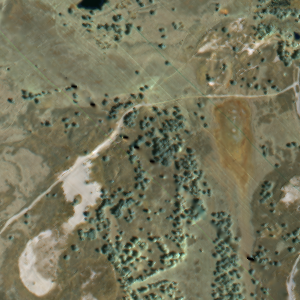

In [3]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

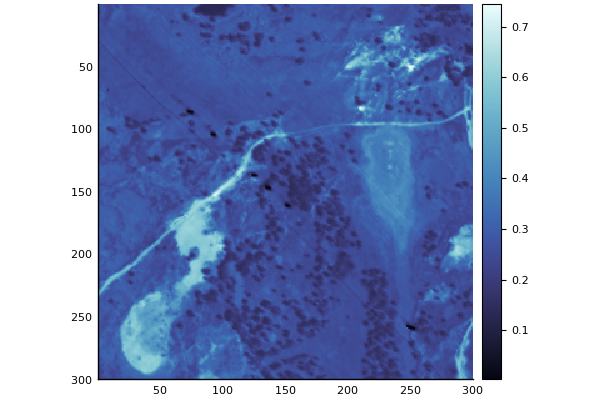

In [4]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

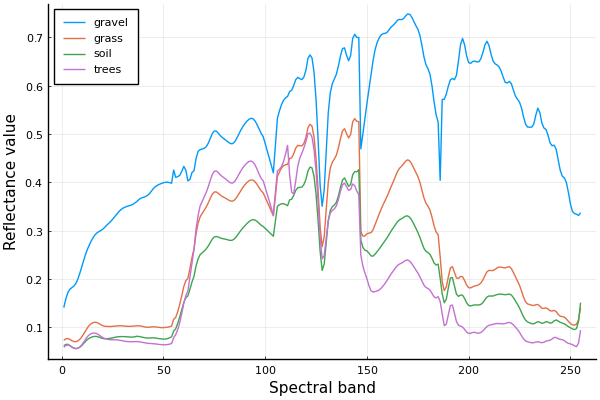

In [5]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [11]:
n = 150^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 50
offset_y = 1
img_small = img[offset_x:offset_x + k - 1,offset_y:offset_y + k - 1, :]

X = reshape(img_small, n, l)'
S = sources;

In [ ]:
include("./interior_point_leat_square.jl")
a, loss = interior_point_least_square(X, S);

In [ ]:
plot(loss)

In [ ]:
loss

In [ ]:
println(all(>=(0), a))

In [ ]:
heatmap(
    reshape(S * reshape(a, p, n), 255, 25, 25)[150, :, :], title="original_plot", aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
)

In [ ]:
original_plot = heatmap(
    img_small[:, :, 150], title="original_plot", aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
)

# Projected Gradient (single constraint)

In [8]:
new_X_1c, A_1c, mean_loss_1c = estimate_abundance(X, S, "projected_gradient_1c");

In [9]:
n_pixels, time_1c = get_runtime_series(X, "projected_gradient_1c");

In [10]:
pg_1c_plot = heatmap(
    new_X_1c[:, :, 150], title="projected_gradient_1c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Projected Gradient (two constraints)

In [11]:
new_X_2c, A_2c, mean_loss_2c = estimate_abundance(X, S, "projected_gradient_2c");

In [12]:
n_pixels, time_2c = get_runtime_series(X, "projected_gradient_2c");

In [13]:
pg_2c_plot = heatmap(
    new_X_2c[:, :, 150], title="projected_gradient_2c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Log-barrier method

In [14]:
new_X_lb, A_lb, mean_loss_lb, loss = estimate_abundance(X, S, "log_barrier");

In [15]:
n_pixels, time_lb = get_runtime_series(X, "log_barrier");

In [16]:
lb_plot = heatmap(
    new_X_lb[:, :, 150], title="log_barrier", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
);

# Model Comparison

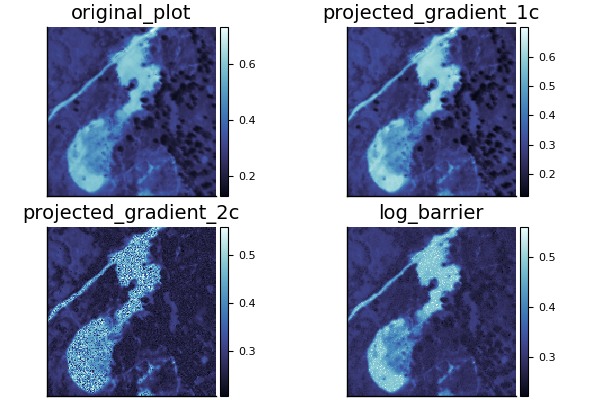

In [17]:
p = plot(original_plot, pg_1c_plot, pg_2c_plot, lb_plot, layout=(2, 2))

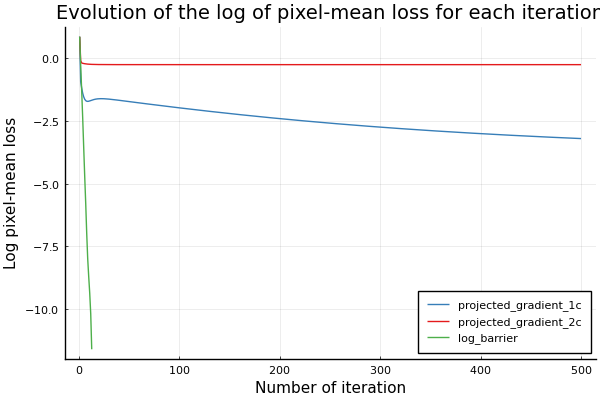

In [18]:
plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    label="log_barrier",
    color="#4daf4a"
)

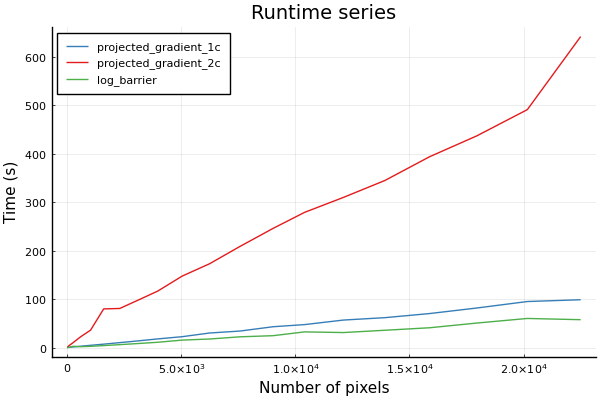

In [19]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_1c,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    n_pixels2, time_2c,
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)

In [4]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [12]:
@everywhere include("./unmixing.jl");
@everywhere using SharedArrays

In [13]:
dX = SharedArray(X);
dS = SharedArray(S);

In [14]:
@time new_X_lb, A_lb, mean_loss_lb, loss = @everywhere estimate_abundance(dX, dS, "log_barrier");

LoadError: On worker 2:
UndefVarError: dX not defined
top-level scope at none:1
eval at ./boot.jl:331
#103 at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:290
run_work_thunk at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:79
run_work_thunk at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:88
#96 at ./task.jl:356

...and 2 more exception(s).


In [31]:
@everywhere function my_func(x)
    return x^3*cos(x)
end

@btime pmap(my_func, 1:10)

  1.822 ms (655 allocations: 22.05 KiB)


10-element Array{Float64,1}:
    0.5403023058681398
   -3.3291746923771393
  -26.729797408212026
  -41.833191735271164
   35.45777318290328
  207.39678191647906
  258.58847323975345
  -74.49601731001013
 -664.2139609139294
 -839.0715290764524

In [32]:
function test()
    for x in 1:10
        x^3*cos(x)
    end
end

@btime test()

  101.076 ns (0 allocations: 0 bytes)


In [145]:
include("./utils.jl")
# Initialization
A0 = get_feasible_point_matrix(p, n)
U = get_feasible_point_matrix(p - 1, n)
z = zeros(p - 1)
z[p-1] = -1
Z = hcat(Bidiagonal(ones(p - 1), -ones(p - 2), :U), z)'
A = A0 + Z * U

# Vectorize A and U
a = reshape(A, n * p)

λ = reshape(get_feasible_point_matrix(p, n), p * n)
Λ = Diagonal(λ)
A_diag = Diagonal(a)

θ = 0.5
δ = a' * λ
μ = (θ * δ) / (P * N)
Mu = μ * ones(N * P)
μ_min = 1e-9  # > 0

∇ϕ = get_gradient_vector(X, S, U)
∇2ϕ = get_hessian_vector(X, S, U)
r_prim = ∇ϕ - λ
η_prim = 100  # > 0
ϵ_prim = η_prim * μ

η_dual = 1.9  # In [1, 1/θ]
ϵ_dual = η_dual * μ


∇ϕ = get_gradient_vector(X, S, U)

d_a = inv(∇2ϕ + inv(A_diag) * Λ) * (-∇ϕ + inv(A_diag) * Mu)
d_λ = inv(A_diag) * (Mu - Λ * (a + d_a))

2500-element Array{Float64,1}:
  0.01124587667421993
 -0.6748372948893334
 -0.7633015035254401
 -0.9191807704016733
 -0.04559894056285874
 -0.13229492708211693
 -0.4611182014097001
 -0.7588350831566767
 -0.3596804635030439
 -0.059548694900258575
  0.05749563430460881
  0.5032470104656475
  0.00468948667214504
  ⋮
 -0.08077819237315621
 -0.871842455237569
 -0.8844033435226922
 -0.6631995925710061
 -0.23888008361796453
 -0.5289781822817832
 -0.4477924437494946
 -0.10469904736591872
  0.020460977381157253
 -1.5318147301867426
 -0.9800782444299936
 -1.5040487790157335